In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import pandas as pd

from src.models.time_series_model import TimeSeriesModel
from src.special_preprocessing.second_special_pipeline.pipeline import preprocessing_pipeline
from src.utils import train_test_split_by_months
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from src.metrics.forecast_accuracy import forecast_accuracy
from random import seed
import numpy as np

from prophet import Prophet

In [32]:
seed(42)
np.random.seed(42)

In [33]:
preprocessing_pipeline.steps[-1][1].production_mode = False

In [34]:
data = pd.read_csv("../datasets/second_dataset/week_sales.csv", parse_dates=["date"], index_col=False)
data = data[(data["CUSTOMER_CODE"] == "customer2") & (data["date"] < pd.Timestamp("2019-01-01"))]

In [35]:
X_marked = train_test_split_by_months(data, date_column="date", test_months=3)

In [36]:
X = preprocessing_pipeline.fit_transform(X_marked)

In [37]:
X_train, y_train = X[X["mark"] == "train"].drop(columns =["ship", "mark"]), X[X["mark"] == "train"]["ship"]
X_test, y_test = X[X["mark"] == "test"].drop(columns=["ship", "trend", "seasonal", "mark"]), X[X["mark"] == "test"]["ship"]

In [38]:
from configs.models_configs import ModelsConfigs
from configs.models_collector import ModelsCollector

selector = ModelsCollector(ModelsConfigs)
trend_models = selector.get_configs(["KNeighborsRegressor", "SVR"])
seasonal_models = selector.get_configs(["XGBRegressor", "GradientBoostingRegressor", "CatBoost"])
tscv = TimeSeriesSplit(n_splits=4)
tsm = TimeSeriesModel(trend_models, seasonal_models, cv=tscv, scoring="neg_mean_absolute_error")

In [39]:
tsm.fit(X_train)
tsm_prediction = tsm.predict(X_test)
tsm_prediction["Actual"] = y_test.values

In [40]:
X_train["y"] = y_train.values
X_train = X_train.drop(columns = ["seasonal", "trend"])
X_train = X_train.rename(columns = {"date": "ds"})
X_test = X_test.rename(columns = {"date": "ds"})

In [41]:
probnet_prediction = pd.DataFrame()
excluded_columns = ['ds', 'y', "key"]
for key in X_train["key"].unique():
    m = Prophet(seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=True,)
    for col in X_train.columns:
        if col not in excluded_columns:
            m.add_regressor(col)

    m.fit(X_train[X_train["key"] == key])
    pred = m.predict(X_test[X_test["key"] == key])
    pred["key"] = key
    probnet_prediction = pd.concat([probnet_prediction, pred])
probnet_prediction = probnet_prediction.rename(columns = {"ds": "date", "yhat": "Forecast"})
probnet_prediction["Actual"] = y_test.values

17:09:39 - cmdstanpy - INFO - Chain [1] start processing
17:09:40 - cmdstanpy - INFO - Chain [1] done processing
17:09:41 - cmdstanpy - INFO - Chain [1] start processing
17:09:41 - cmdstanpy - INFO - Chain [1] done processing
17:09:43 - cmdstanpy - INFO - Chain [1] start processing
17:09:43 - cmdstanpy - INFO - Chain [1] done processing
17:09:45 - cmdstanpy - INFO - Chain [1] start processing
17:09:45 - cmdstanpy - INFO - Chain [1] done processing
17:09:47 - cmdstanpy - INFO - Chain [1] start processing
17:09:48 - cmdstanpy - INFO - Chain [1] done processing
17:09:50 - cmdstanpy - INFO - Chain [1] start processing
17:09:51 - cmdstanpy - INFO - Chain [1] done processing
17:09:52 - cmdstanpy - INFO - Chain [1] start processing
17:09:53 - cmdstanpy - INFO - Chain [1] done processing
17:09:54 - cmdstanpy - INFO - Chain [1] start processing
17:09:55 - cmdstanpy - INFO - Chain [1] done processing
17:09:56 - cmdstanpy - INFO - Chain [1] start processing
17:09:56 - cmdstanpy - INFO - Chain [1]

In [42]:
result = forecast_accuracy(tsm_prediction, time_period="ME")[["date", "Acc"]]
result = result.rename(columns = {"Acc": "TSM Acc"})
result["ProbNet Acc"] = forecast_accuracy(probnet_prediction, time_period="ME")["Acc"].values

In [43]:
result

,date,TSM Acc,ProbNet Acc
0,2018-09-30,0.000000,0.800890
1,2018-10-31,0.959342,0.414613
2,2018-11-30,0.911237,0.428232
3,2018-12-31,0.834095,0.617723


In [44]:
result = forecast_accuracy(tsm_prediction, time_period="YE")[["date", "Acc"]]
result = result.rename(columns = {"Acc": "TSM Acc"})
result["ProbNet Acc"] = forecast_accuracy(probnet_prediction, time_period="YE")["Acc"].values

In [45]:
result

,date,TSM Acc,ProbNet Acc
0,2018-12-31,0.964263,0.881389


In [46]:
result = forecast_accuracy(tsm_prediction, time_period="ME", ae_gr_cols=["key"])[["date", "key", "Acc"]]
result = result.rename(columns = {"Acc": "TSM Acc"})
result["ProbNet Acc"] = forecast_accuracy(probnet_prediction, time_period="ME", ae_gr_cols=["key"])["Acc"].values
result["key"] = pd.factorize(result["key"])[0] + 1

In [47]:
result

,date,key,TSM Acc,ProbNet Acc
0,2018-09-30,1,0.000000,0.057445
1,2018-09-30,2,0.000000,0.007159
2,2018-09-30,3,0.000000,0.323422
3,2018-09-30,4,0.000000,-0.314906
4,2018-09-30,5,0.000000,-0.134016
...,...,...,...,...
1099,2018-12-31,272,0.000000,0.000000
1100,2018-12-31,273,0.211836,0.000000
1101,2018-12-31,274,0.998965,0.000000
1102,2018-12-31,275,0.907780,0.000000


In [48]:
result = forecast_accuracy(tsm_prediction, time_period="YE", ae_gr_cols=["key"])[["date", "key", "Acc"]]
result = result.rename(columns = {"Acc": "TSM Acc"})
result["ProbNet Acc"] = forecast_accuracy(probnet_prediction, time_period="YE", ae_gr_cols=["key"])["Acc"].values
result["key"] = pd.factorize(result["key"])[0] + 1

In [49]:
result

,date,key,TSM Acc,ProbNet Acc
0,2018-12-31,1,0.537186,0.007085
1,2018-12-31,2,-0.809077,0.004879
2,2018-12-31,3,0.617597,0.222090
3,2018-12-31,4,0.532608,-0.011869
4,2018-12-31,5,0.576067,-0.059894
...,...,...,...,...
271,2018-12-31,272,0.542115,0.000000
272,2018-12-31,273,0.103565,0.000000
273,2018-12-31,274,0.852147,0.000000
274,2018-12-31,275,0.939892,0.000000


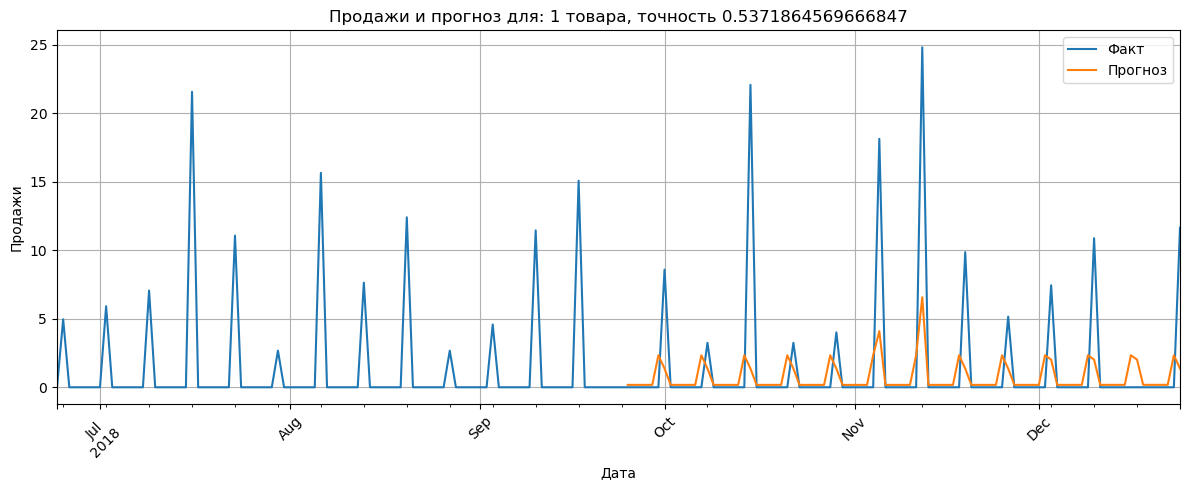

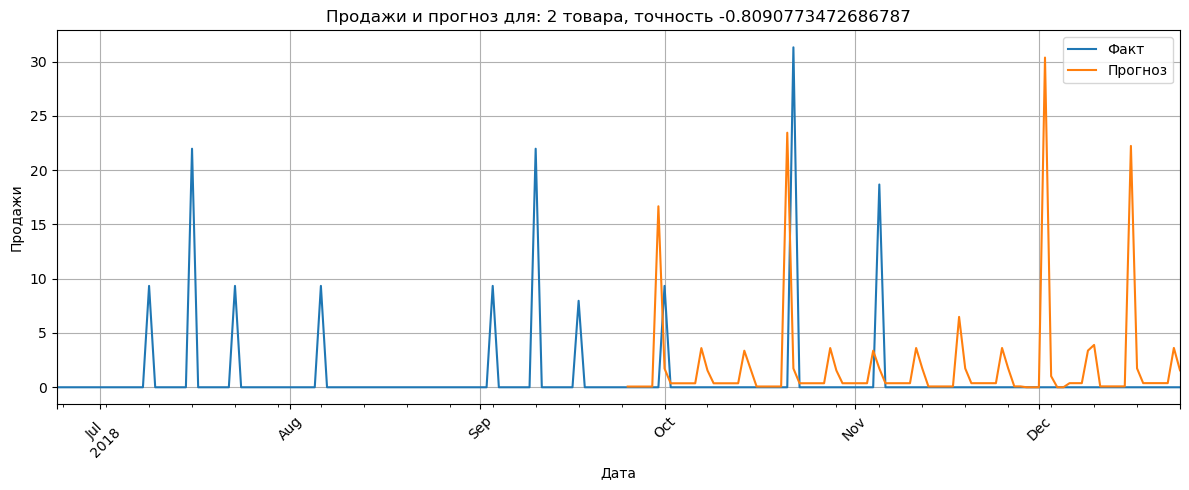

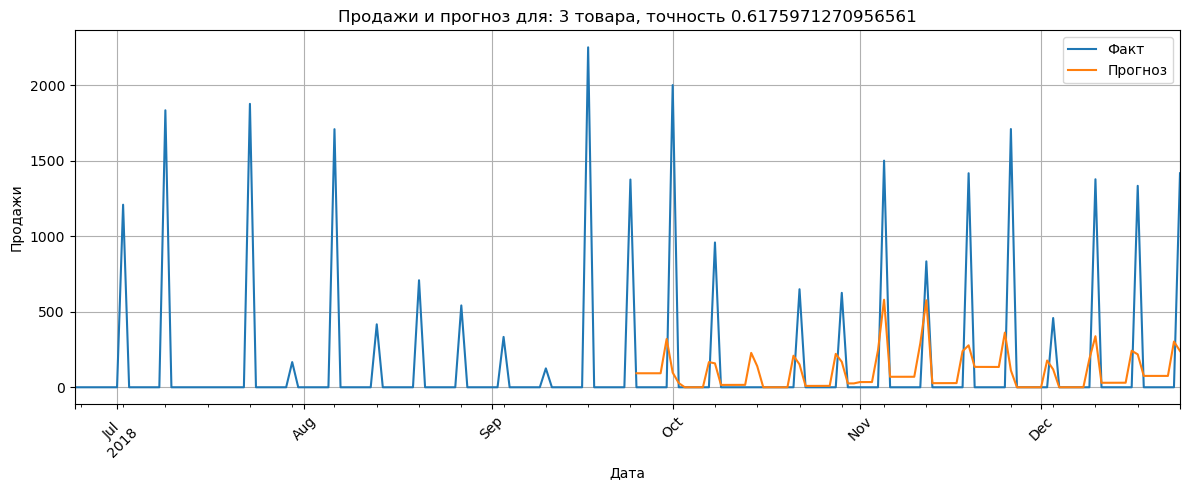

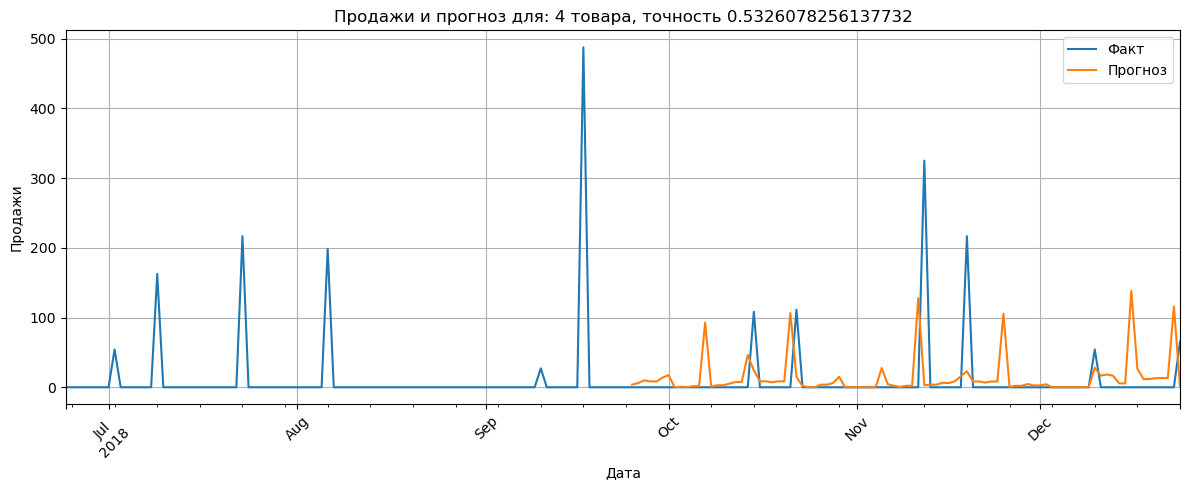

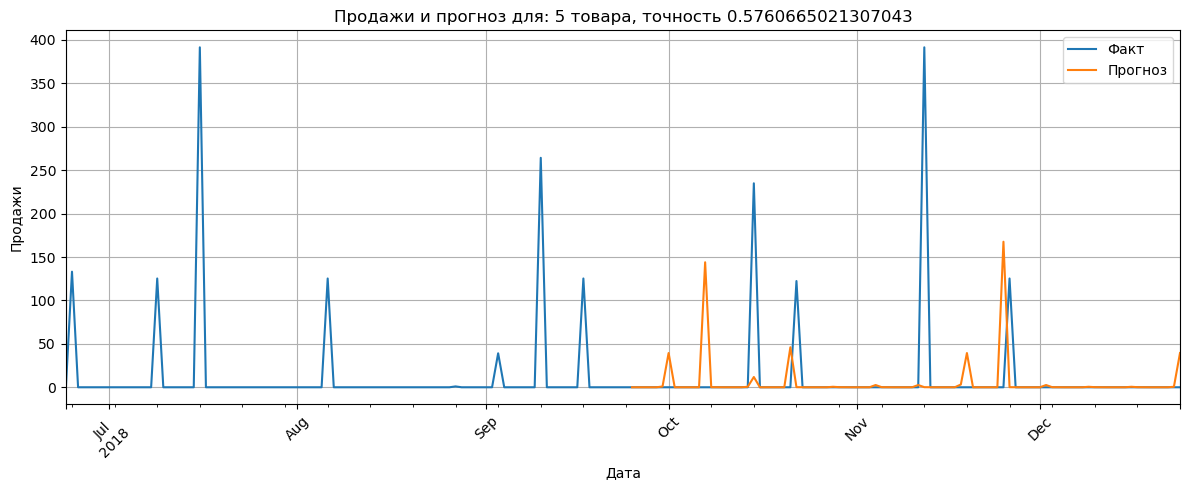

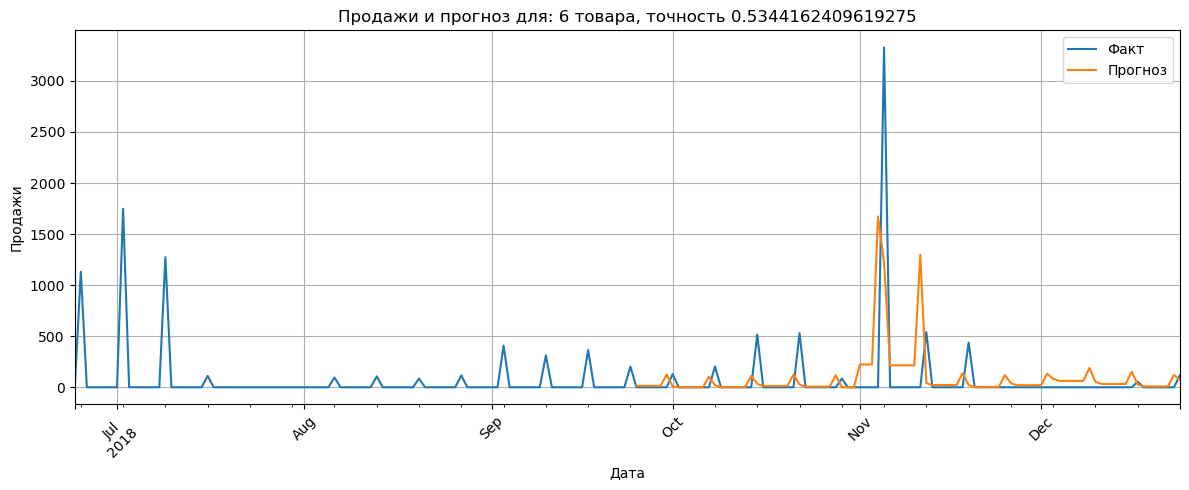

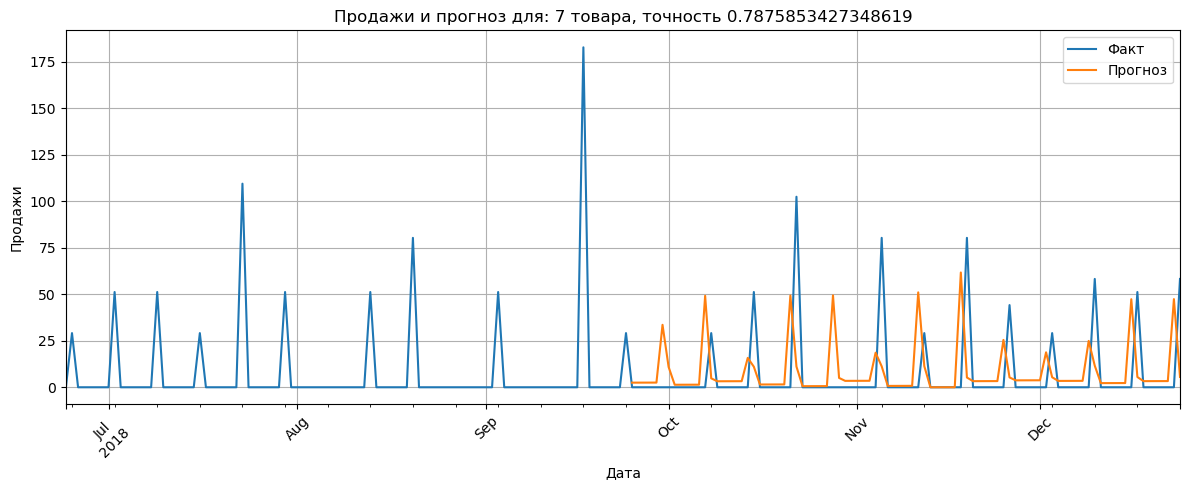

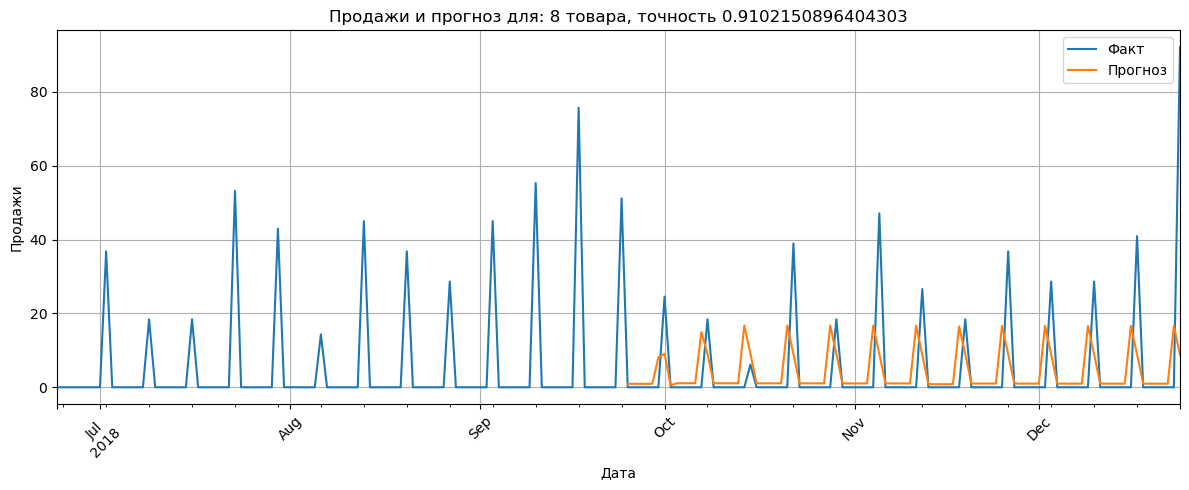

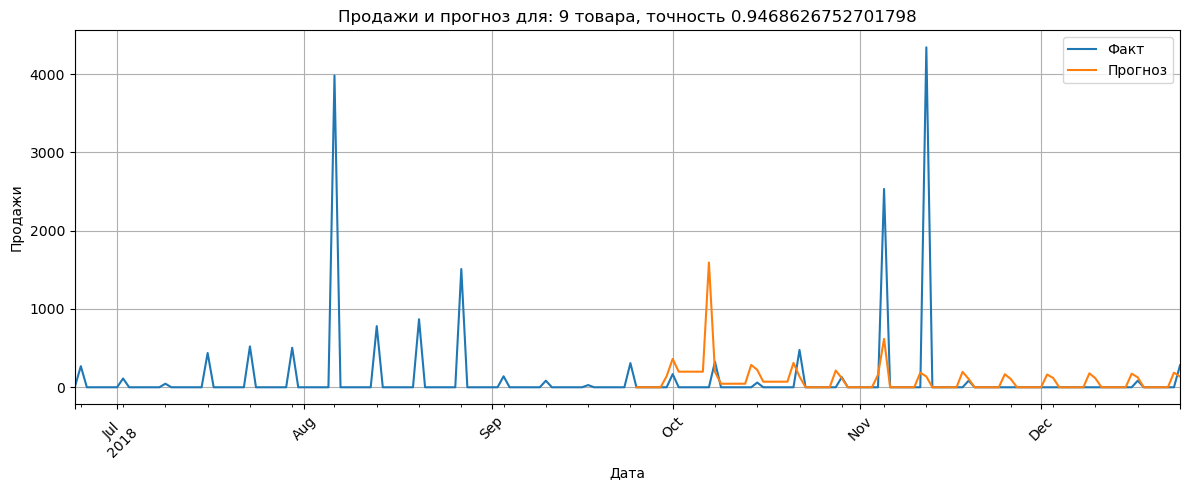

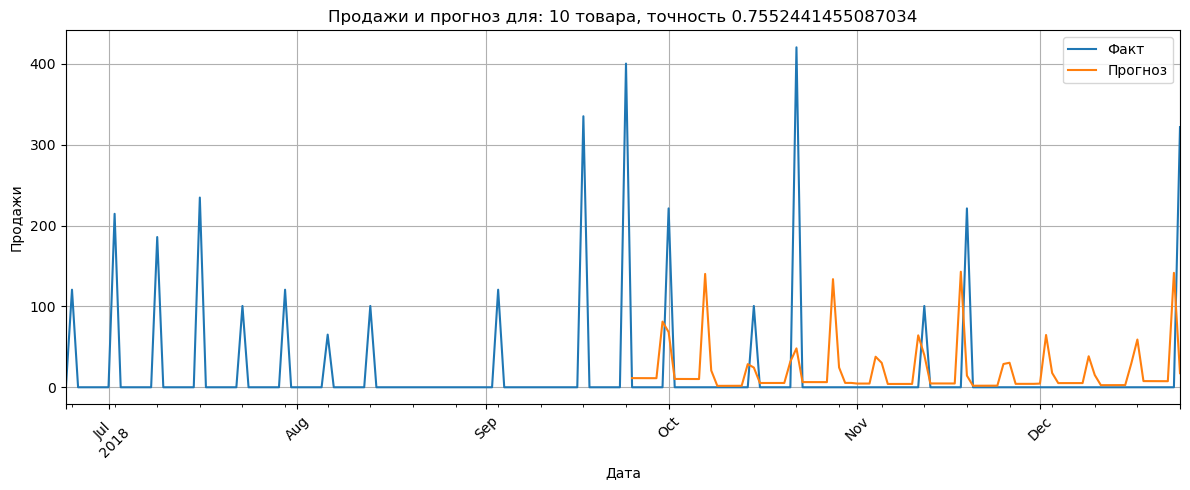

In [53]:
keys = X["key"].unique()[:10]

for idx, key in enumerate(keys, 1):
    pred_key_df = tsm_prediction[tsm_prediction["key"] == key]
    last_pred_date = pred_key_df["date"].max()
    start_date = last_pred_date - pd.DateOffset(months=6)

    real_key_df = X[(X["key"] == key) & (X["date"] >= start_date) & (X["date"] <= last_pred_date)]

    combined_df = pd.merge(
        real_key_df[["date", "key", "ship"]], pred_key_df[["date", "key", "Forecast"]], on=["date", "key"], how="outer"
    )

    combined_df = combined_df.sort_values("date").set_index("date")
    key_acc = result[result["key"] == idx]["TSM Acc"].values[0]
    combined_df[["ship", "Forecast"]].plot.line(figsize=(12, 5), title=f"Продажи и прогноз для: {idx} товара, точность {key_acc}")
    plt.xlabel("Дата")
    plt.ylabel("Продажи")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(["Факт", "Прогноз"])
    plt.tight_layout()
    plt.show()